# Rapid Iteration with Point Estimation - Lotka-Volterra Dynamics

_Author: Hans Olischläger_

In this notebook, we will infer parameters of a famous ecology differential equation with BayesFlow.

We will follow a typical workflow that emphazises rapid iterations early on, before building up towards reliable estimates of the full posterior with end-to-end data embedding.

In [1]:
import os

if not os.environ.get("KERAS_BACKEND"):
    # Set to your favorite backend
    os.environ["KERAS_BACKEND"] = "jax"

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy.integrate import odeint

import keras

import bayesflow as bf

INFO:bayesflow:Using backend 'jax'


In [2]:
# avoid scientific notation for outputs
np.set_printoptions(suppress=True)

## Ecology Simulator

Suppose we measured population counts from two species over time. One of them preys on the other, so we might assume that the dynamics are governed by the classic Lotka-Volterra system. In dimensionless form, with prey population $x$ and predator population $y$, the nonlinear differential equation is

$$
\begin{aligned}{\frac {dx}{dt}}&=\alpha x-\beta xy,\\{\frac {dy}{dt}}&=-\gamma y+\delta xy.\end{aligned}
$$

As always, this model entails a number of assumptions that can only be approximate. In brief:
On their own, prey count increases exponentially with rate $\alpha$, while predator count decays with rate $\gamma$.
Interesting dynamics are possible when both predators and prey are present: The number of predators increases the more prey it can hunt, reducing prey counts proportionally at a rate $\beta$ and increasing predator count proportionally at a rate $\delta$.

We can measure population timeseries, but never the parameters directly, so this is a scientifically relevant inverse problem.

The Lotka-Volterra equations alone are not yet a concrete testable hypothesis, since it does not on its own predict anything measureable. We must pick parameters, initial conditions, and an observation model which describes how measurements take place. Note: the wide applicability of simulation-based inference is due to the fact that scientific hypotheses typically come in the form of simulators of measurable quantities.

Our simulator will consist of three parts:
1. First, we choose a prior distribution over parameters that reflects our beliefs about parameters before observing data.
2. Building on parameters sampled from the prior, we solve the parameterized Lotka-Volterra equation starting from some initial conditions.
3. Finally, we hypothesize that we will make some counting errors when observing the populations, introducing a Gaussian error on the true populations.

A random number generator with a fixed seed will ensure reproducibility of the simulated training and validation data.

In [3]:
rng = np.random.default_rng(seed=1234)

In [5]:
def prior():
    x = rng.normal(size=4)
    theta = 1/(1+np.exp(-x)) * 3.9 + 0.1 # logit normal distribution scaled to range from 0.1 and 4
    return dict(
        alpha=theta[0],
        beta=theta[1],
        gamma=theta[2],
        delta=theta[3],
    )


def lotka_volterra_equations(state, t, alpha, beta, gamma, delta):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = - gamma * y + delta * x * y
    return [dxdt, dydt]


def ecology_model(alpha, beta, gamma, delta, t_span=[0, 5], t_steps=100, initial_state=[1, 1]):
    t = np.linspace(t_span[0], t_span[1], t_steps)
    state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))
    x, y = state.T  # Transpose to get x and y arrays
    
    return dict(
        x=x,  # Prey time series
        y=y,  # Predator time series
        t=t,  # time
    )


def observation_model(x, y, t, subsample=10, obs_prob=1.0, noise_scale=0.1):
    t_steps = x.shape[0]
    
    # Add Gaussian noise to observations
    noisy_x = rng.normal(x, noise_scale)
    noisy_y = rng.normal(y, noise_scale)
    
    # Determine which time steps are observed
    step_indices = np.arange(0, t_steps, subsample)
    num_observed = int(obs_prob * len(step_indices))
    observed_indices = np.sort(rng.choice(step_indices, num_observed, replace=False))

    return {
        "observed_x": noisy_x[observed_indices],
        "observed_y": noisy_y[observed_indices],
        "observed_t": t[observed_indices]
    }

We can combine these three components into a BayesFlow simulator via:

In [6]:
simulator = bf.make_simulator([prior, ecology_model, observation_model])

Let's sample 1000 trajectories, and see what we get:

In [7]:
num_trajectories = 1000
samples = simulator.sample(num_trajectories)
keras.tree.map_structure(keras.ops.shape, samples)

{'alpha': (1000, 1),
 'beta': (1000, 1),
 'gamma': (1000, 1),
 'delta': (1000, 1),
 'x': (1000, 100),
 'y': (1000, 100),
 't': (1000, 100),
 'observed_x': (1000, 10),
 'observed_y': (1000, 10),
 'observed_t': (1000, 10)}

What types of developments (and observations) does our Lotka-Volterra simulator predict? We should have a function to visualize sampled trajectories and take a look!

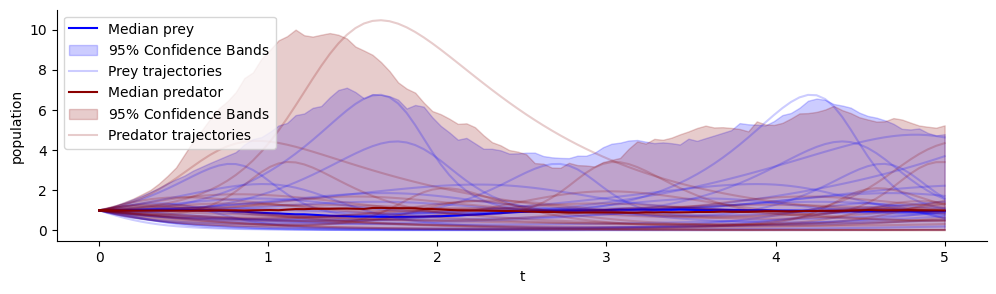

In [8]:
def trajectory_aggregation(traj, confidence=0.95):
    alpha = 1 - confidence
    quantiles = np.quantile(traj, [alpha/2, 0.5, 1-alpha/2], axis=0).T
    central = quantiles[:,1]
    L = quantiles[:,0]
    U = quantiles[:,2]
    return central, L, U

def plot_trajectores(samples, variable_keys, variable_names, fill_colors=["blue", "darkred"], confidence=0.95, alpha=0.8, observations=None, ax=None):
    t_span = samples["t"][0]
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12,3))
        sns.despine()
    
    for i, key in enumerate(variable_keys):

        if observations is not None:     
            ax.scatter(observations["observed_t"], observations["observed_"+key], color=fill_colors[i], marker="x", label="Observed " + variable_names[i].lower())

        central, L, U = trajectory_aggregation(samples[key], confidence=confidence)
        ax.plot(t_span, central, color=fill_colors[i], label="Median " + variable_names[i].lower())
        ax.fill_between(t_span, L, U, color=fill_colors[i], alpha=0.2, label=rf"{int((confidence) * 100)}$\%$ Confidence Bands")

        # plot 20 trajectory samples
        for j in range(20):
            if j == 0:
                label = f"{variable_names[i]} trajectories"
            else:
                label = None
            ax.plot(t_span, samples[key][j], color=fill_colors[i], alpha=0.2, label=label)
        

    ax.legend()
    ax.set_xlabel("t")
    ax.set_ylabel("population")

plot_trajectores(samples, ["x", "y"], ["Prey", "Predator"])

Above, we see the prior predictive distribution of the simulator. The shaded area contains 95% of trajectories at each timestep, additionally we see a few example trajectories.

Predator and prey populations generally oscillate in this model. But the frequency, amplitude, relative lag, and scale varies greatly for different parameters.

The prior predictive distribution should match our expectation of the real world system of interest before we take into account concrete observed population counts.
Here, we see the prior implies population magnitudes to oscillate (mostly) below 6.

## Rapid Inference

The first goal will be to get a fast but crude approximation of the true posteriors for different observations. Two ingredients will allow us to move fast towards parameter inference:

1. Basic hand-crafted summary statistics
2. Point estimation

This will help us diagnose challenges with the simulator and establishes a baseline for the final goal: full posterior inference.

### Domain Expert Statistics

Ultimately, we want to learn maximally informative summary statistics jointly with an amortized posterior approximation, but hand crafted summary statistics have the benefit of being interpretable and fast to compute. Oftentimes, there are a few natural and established statistics for a particular modality of raw data. Researchers of the field are likely to have made significant progress in finding closed form expressions or algorithms for informative summaries.

Compared to the theoretically optimal summary statistics, we can expect there to be less posterior contraction.

Still, we can reasonably expect, that oscillation period, mean, (log) variance, autocorrelation at different lags of both trajectories, and the cross correlation between the two trajectories are highly informative when taken together as summary statistics.

In [9]:
def period(observed_x, t_span=[0, 5], t_steps=500):
    """
    Computes the dominant period of observed_x from a periodogram.
    """
    f, Pxx = scipy.signal.periodogram(observed_x, t_steps/(t_span[1]-t_span[0]))
    freq_dominant = f[np.argmax(Pxx)]
    T = 1 / freq_dominant
    return T


def autocorr(trajectory, lags):
    """
    Computes the autocorrelation for each specified lag in a trajectory.
    
    Parameters
    ----------
    trajectory : np.ndarray
        The time series data, assumed to be a 1D array.
    lags : np.ndarray or list
        The lags at which to compute the autocorrelation.
    
    Returns
    -------
    auto_correlation : np.ndarray
        Autocorrelation values at each specified lag.
    """
    # Calculate the mean and variance of the trajectory for normalization
    mean = np.mean(trajectory)
    var = np.var(trajectory)
    
    # Initialize an array to hold the autocorrelation values
    auto_correlation = np.zeros(len(lags))
    
    # Compute autocorrelation for each lag
    for i, lag in enumerate(lags):
        if lag == 0:
            # Autocorrelation at lag 0 is always 1
            auto_correlation[i] = 1
        elif lag >= len(trajectory):
            # If the lag is equal to or greater than the length of the trajectory, autocorrelation is undefined (set to 0)
            auto_correlation[i] = 0
        else:
            # Compute covariance and then autocorrelation
            cov = np.mean((trajectory[:-lag] - mean) * (trajectory[lag:] - mean))
            auto_correlation[i] = cov / var

    if np.any(np.isnan(auto_correlation)):
        print(auto_correlation)
            
    return auto_correlation

def crosscorr(x, y):
    """
    Computes the cross-correlation (Pearson correlation coefficient) between two trajectories at zero lag.

    Parameters
    ----------
    x : np.ndarray
        The first time series data, assumed to be a 1D array of length n.
    y : np.ndarray
        The second time series data, assumed to be a 1D array of length n.

    Returns
    -------
    float
        The cross-correlation coefficient.
    """
    # Compute the mean and standard deviation of both time series
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)

    # Compute the covariance and the correlation coefficient
    covariance = np.mean((x - mean_x) * (y - mean_y))
    correlation = covariance / (std_x * std_y)

    return correlation

def expert_stats(observed_x, observed_y, lags=[2,5]):
    """Computes fixed size statistics for an observed population trajectory

    Parameters
    ----------
    observed_x : np.ndarray with shape (num_observations, )
    observed_y : np.ndarray with shape (num_observations, )

    Returns
    -------
    dictionary with the following keys and values
    means      : np.ndarray with shape (2,)
    log_vars   : np.ndarray with shape (2,)
    auto_corrs : np.ndarray with shape (2*num_lags,)
        auto-correlation of each timeseries at lags 0.2 and 0.4 time units
    cross_corr : np.ndarray with shape (1,)
        the cross-correlation between the two time series
    period     : np.ndarray with shape (1,)
    """
    means = np.array([observed_x.mean(), observed_y.mean()])
    log_vars = np.log(np.array([observed_x.var(), observed_y.var()]))
    auto_corrs = np.array([
        autocorr(observed_x,lags),
        autocorr(observed_y,lags),
    ]).flatten()
    cross_corr = crosscorr(observed_x, observed_y)
    T = period(observed_x)
    
    return dict(
        means=means,
        log_vars=log_vars,
        auto_corrs=auto_corrs,
        cross_corr=cross_corr,
        period=T,
    )

To compute the expert statistics we can append the `expert_stats` function to the `simulator` object.

In [10]:
simulator = bf.make_simulator([prior, ecology_model, observation_model, expert_stats])

In [11]:
samples_with_expert_stats = simulator.sample(3)
keras.tree.map_structure(keras.ops.shape, samples_with_expert_stats)

{'alpha': (3, 1),
 'beta': (3, 1),
 'gamma': (3, 1),
 'delta': (3, 1),
 'x': (3, 100),
 'y': (3, 100),
 't': (3, 100),
 'observed_x': (3, 10),
 'observed_y': (3, 10),
 'observed_t': (3, 10),
 'means': (3, 2),
 'log_vars': (3, 2),
 'auto_corrs': (3, 4),
 'cross_corr': (3, 1),
 'period': (3, 1)}

### Point estimation

Ultimately, we want to infer the full posterior distribution, but it can be much faster to infer point estimates of the same and already allow us to diagnose whether inference is or can be successful for a particular simulator.
Thus, in the spirit of rapid iteration we will first target the posterior mean and a few quantiles.

BayesFlow provides a convenient interface for point estimation. Here is a brief explantion of the principle:

Each point estimator is obtained by minimizing the Bayes risk for a particular loss function. Depending on the loss function, the resulting estimator will faithfully estimate a different functional of the full posterior distribution. 

Typically, we refer to such loss functions as *scores* or *scoring rules* for a particular probabilistic forecast, since they score forecasts of a distribution $p(\theta|x)$ based on samples $\theta \sim p(\theta|x)$ of that distribution.
If the true forecast is the best forecast under the score, i.e. optimizes the score (uniquely), such losses are called **(strictly) proper scoring rules**. 

* Here is a strictly proper scoring rule that is optimal if the estimate, $\hat \theta$, is the true **mean** of the posterior:

    $$L(\hat \theta, \theta; k) = | \theta - \hat \theta |^2$$

    It is the well known squared error loss!

* Similarly, since median minimizes the expected absolute distance to $\theta \sim p(\theta|x)$, we know that the corresponding loss is optimized by the true **median** of the posterior.

    $$L(\hat \theta, \theta; k) = | \theta - \hat \theta |$$

* To estimate **quantiles**, the following is a strictly proper scoring rule:

    $$L(\hat \theta, \theta; \tau) = (\hat \theta - \theta)(\mathbf{1}_{\hat \theta - \theta > 0} - \tau)$$

    Here we write an indicator function as $\mathbf{1}_{\hat \theta - \theta > 0}$ to evaluate to 1 for overestimation (positive $\hat \theta - \theta$) and $0$ otherwise.

    For $\tau=\frac 1 2$, over- or underestimating a true posterior sample $\theta$ is weighted equally. In fact, the quantile loss with $\tau=\frac 1 2$ is identical to the median loss (up to a scaling of $\frac 1 2$). For the same reasons, both estimate the median of the posterior.

    More generally, $\tau \in (0,1)$ is the quantile level, that is the point where to evaluate the [quantile function](https://en.wikipedia.org/wiki/Quantile_function).


* Note, that when approximating the full distribution in BayesFlow we score a **probability estimate** $\hat p(\theta|x)$ with the log-score,

    $$L(\hat p(\theta|x), \theta) = \log (\hat p(\theta))$$

    which is also a strictly proper scoring rule.


* What if you want to estimate something else? There might just be a loss function that corresponds to the estimator of exactly the quantity you are after.

    The class of functions that leads to faithful estimators is called *strictly proper scoring rules*.
    A good reference for the theory and examples is the following [paper](https://doi.org/10.1198/016214506000001437).

    Gneiting, T., & Raftery, A. E. (2007). Strictly Proper Scoring Rules, Prediction, and Estimation. *Journal of the American Statistical Association*, 102(477), 359–378. https://doi.org/10.1198/016214506000001437


If you can find a proper scoring rule for the quantity you want to estimate, implement it as a negatively-oriented loss function, inherit from the abstract `ScoringRule` class and you will be able to use it within BayesFlow.

In [12]:
adapter = (
    bf.adapters.Adapter()

    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories and raw observations
    .drop(["x", "y", "t", "observed_x", "observed_y", "observed_t"])
    
    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["means", "log_vars", "auto_corrs", "cross_corr", "period"], into="inference_conditions")

)
adapter

Adapter([0: ConvertDType -> 1: Drop(['x', 'y', 't', 'observed_x', 'observed_y', 'observed_t']) -> 2: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 3: Concatenate(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period'] -> 'inference_conditions')])

In [13]:
num_training_batches = 512
num_validation_sets = 300
batch_size = 64
epochs = 15

In [14]:
num_training_batches * batch_size

32768

In [15]:
training_data = simulator.sample(num_training_batches * batch_size)
validation_data = simulator.sample(num_validation_sets)

CPU times: total: 21 s
Wall time: 21.2 s


`PointInferenceNetwork`s are defined by the `ScoringRule`s they use to approximate certain point estimates. Passing a dictionary of such `ScoringRule`s will construct a corresponding feed forward model.

In [16]:
q_levels = np.linspace(0.1,0.9,5)

point_inference_network = bf.networks.PointInferenceNetwork(
    scores=dict(
        mean=bf.scores.MeanScore(),
        quantiles=bf.scores.QuantileScore(q_levels),
    ),
)

point_inference_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=point_inference_network,
)

In [ ]:
history = point_inference_workflow.fit_offline(
    training_data,
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

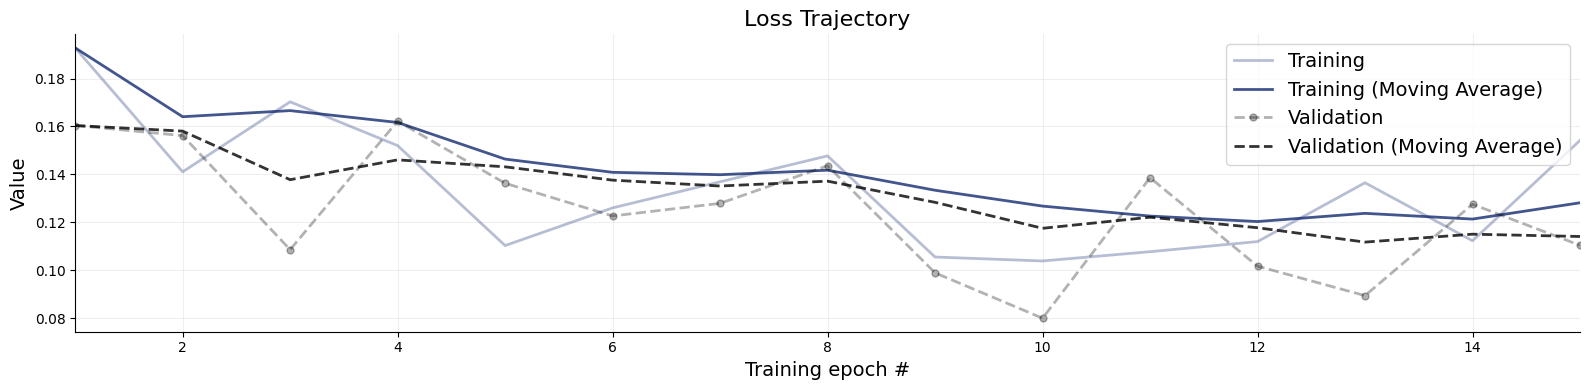

In [18]:
f = bf.diagnostics.loss(history)

Training is completed after a few seconds! 

Just for fun and because we can, let us save the trained point approximator to disk.

In [19]:
checkpoint_path = Path("checkpoints") / "model.keras"
checkpoint_path.parent.mkdir(exist_ok=True)
keras.saving.save_model(point_inference_workflow.approximator, checkpoint_path)

Now we load the approximator again from disk and use it for inference and diagnosis below.

In [20]:
loaded = keras.saving.load_model(checkpoint_path)
point_inference_workflow.approximator = loaded

#### Inference

The computational cost we have payed for training up front is amortized by cheap inference on simulated or measured observations.
This means, we can rapidly evaluate posteriors for different observations not seen in training, which allows for comprehensive diagnosis of posterior quality.

So far so general, but point estimators in particular give a speed advantage not only in training, but also with respect to diagnostics.
Since one point estimate already summarizes many posterior samples, we only have to do one forward pass with a point inference network, where we would have to make ~100 passes with a generative, full posterior approximator.

In [21]:
# Simulate validation data
val_sims = simulator.sample(500)

# estimate posteriors for all conditions 
estimates_point = point_inference_workflow.approximator.estimate(conditions=val_sims)

# `approximator.estimate()` returned a nested dictionary of point estimates for each named parameter,
# see the structure and shape below
keras.tree.map_structure(keras.ops.shape, estimates_point)

{'alpha': {'mean': (500, 1), 'quantiles': (500, 5, 1)},
 'beta': {'mean': (500, 1), 'quantiles': (500, 5, 1)},
 'gamma': {'mean': (500, 1), 'quantiles': (500, 5, 1)},
 'delta': {'mean': (500, 1), 'quantiles': (500, 5, 1)}}

#### Recovery and calibration diagnostics for point estimates

Diagnosing problems with point estimation is done similarly to full posterior approximation. For example, you can check how point estimates relate to ground truth values with a recovery plot. The recovery plot can be used for many different point estimates. Just define which point estimate is displayed with what kind of [matplotlib marker](https://matplotlib.org/stable/api/markers_api.html) in a dictionary.

In [22]:
marker_mapping = dict(quantiles="_", mean="*")

Above we defined horizontal bars to indicate quantile estimates and a star to indicate the estimated mean. Point estimates for the same condition are connected with a line.

We can provide pretty names to plotting functions so we define them once here:

In [23]:
par_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]

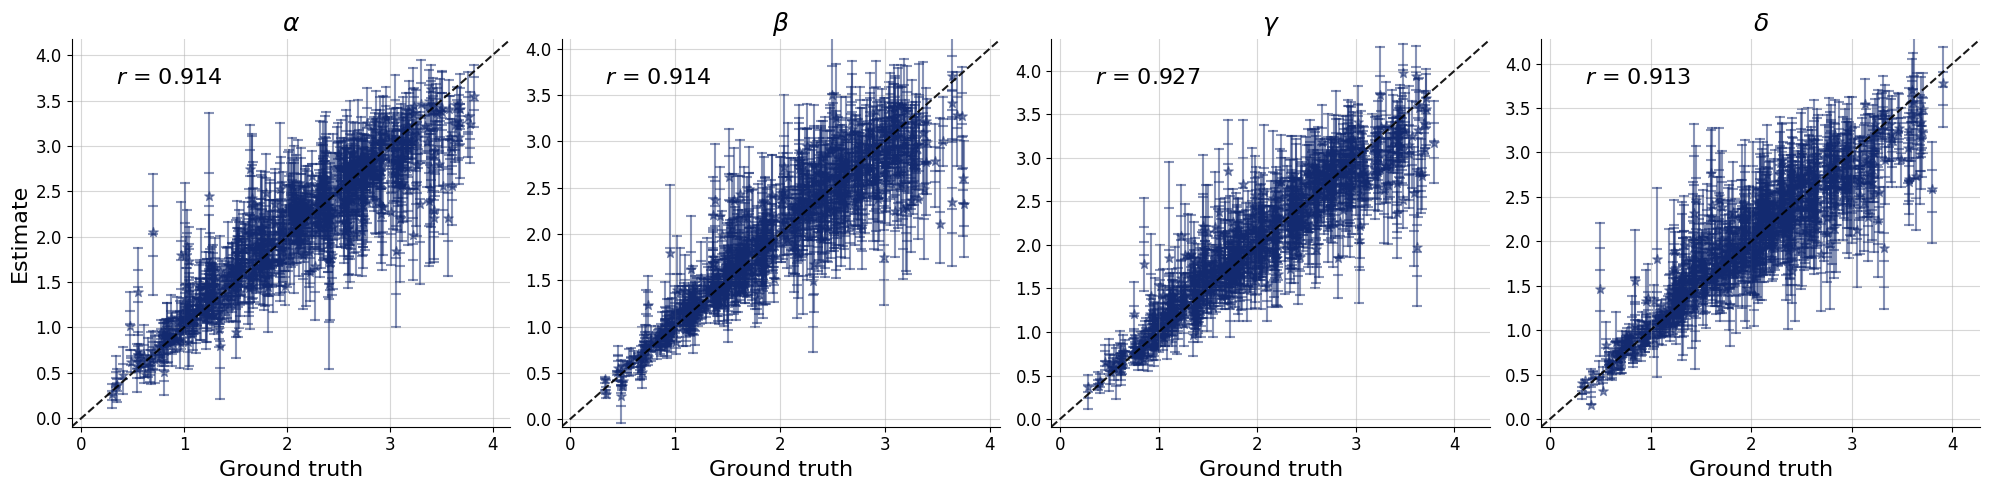

In [24]:
f = bf.diagnostics.plots.recovery_from_estimates(
    estimates=estimates_point,
    targets=val_sims,
    marker_mapping=marker_mapping,
    variable_names=par_names,
    s=50,  # size of markers as in matplotlib.scatter
)

We can and should also perform simulation based calibration checks on the estimated quantiles.

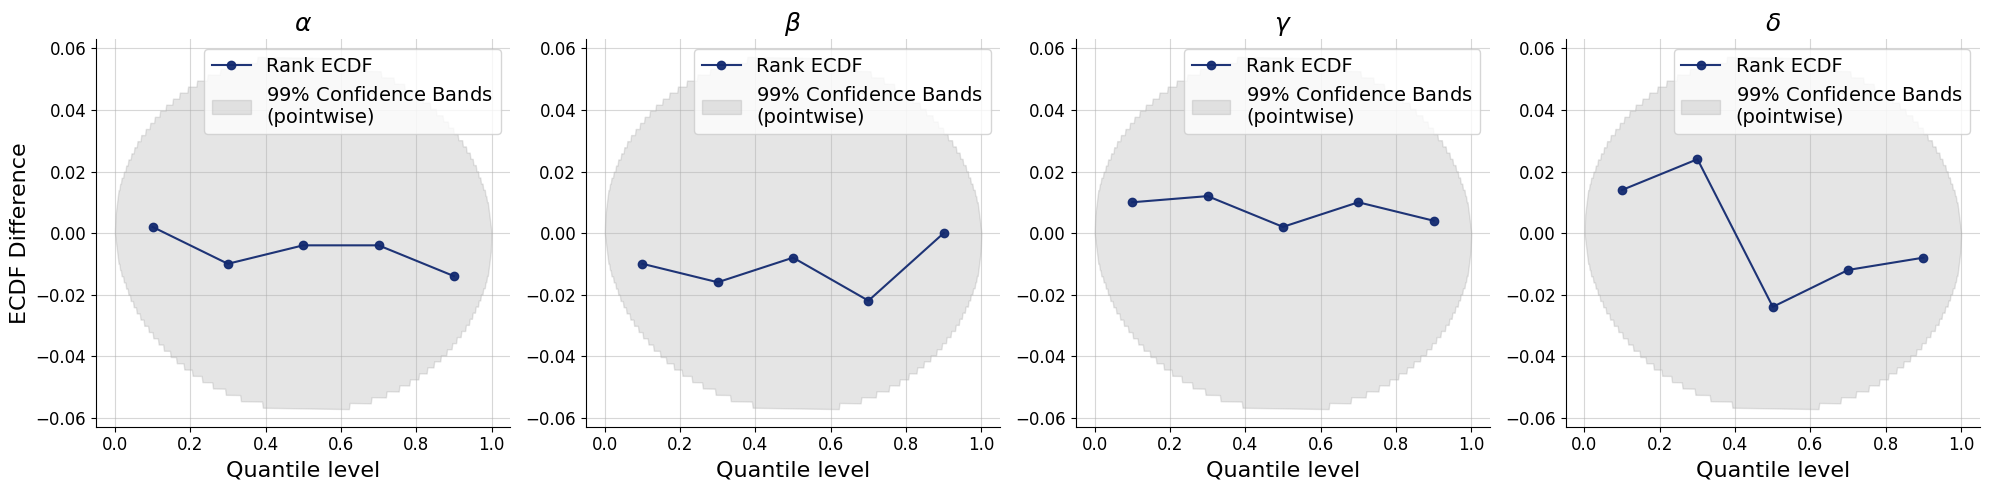

In [25]:
f = bf.diagnostics.plots.calibration_ecdf_from_quantiles(
    estimates=estimates_point, 
    targets=val_sims,
    quantile_levels=q_levels,
    difference=True,
    variable_names=par_names,
)

Neither the recovery nor the calibration diagnostic indicates any problems with the point inferences. Let us go one step further in validation by checking the posterior predictive distribution.


#### Advanced: posterior predictive check from quantile estimates

To sample the posterior we need to assume some concrete probability function. We will choose a diagonal multivariate normal distribution that we construct to be consistent with the quantile estimates.

More concretely, we calculate a mean and standard deviation for every parameter based on its outer most quantile estimates, that is quantile level 0.1 and 0.9.

We start by extracting the lower and upper bound from the quantile posterior approximation:

In [26]:
post_bounds_from_quantiles = keras.tree.map_structure(lambda v: v[:,[0,-1]], {k:v["quantiles"] for k,v in estimates_point.items()})

To translate these estimates to a corresponding mean and standard deviation we consider first the standard normal distribution. We know that we are interested in a translated and scaled version of it and since this is a linear transformation, we can calculate interpolation values $\alpha$ and $\beta$ on the standard normal distribution and obtain mean and standard deviation for the normal distribution of interest.

If $X$ follows a standard normal distribution with the known cumulative distribution function $F_X(x)$, the quantile for the quantile level $\tau_i$ is $\tilde q_i = F_X^{-1}(\tau_{i})$ and we can compute it for both quantile levels corresponding to the bounds we computed above.

In [27]:
# translate two quantile levels (first and last) to quantiles on the standard normal (mean=0, std=1)
stdnormal_q = scipy.stats.norm.ppf(q_levels[[0,-1]])
stdnormal_q

array([-1.28155157,  1.28155157])

In relation to $q_1$ and $q_2$, where is $x=0$ and $x=1$? These two correspond to location (mean) and scale (standard deviation) of the standard normal.

So we solve the equations

$$
\begin{aligned}
    0 &= \tilde q_1 (1-\alpha) + \tilde  q_2 \alpha,\\
    1 &= \tilde q_1 (1-\beta) + \tilde  q_2 \beta,
\end{aligned}
$$

for $\alpha$ and $\beta$ and obtain 

$$
\begin{aligned}
    \alpha &= \frac {\tilde q_1} {\tilde q_1 - \tilde q_2},\\
    \beta &= \frac {\tilde q_1 - 1} {\tilde q_1 - \tilde q_2}.
\end{aligned}
$$

In [28]:
# calculate interpolation value for mean and standard deviation
alpha = stdnormal_q[0] / (stdnormal_q[0] - stdnormal_q[1])       # interpolation value for q=0 (mean = 0 for standard normal)
beta = (stdnormal_q[0] - 1) / (stdnormal_q[0] - stdnormal_q[1])  # interpolation value for q=1 (mean+std = 1 for standard normal)

Since the standard normal and the normal distribution of interest are connected by a *linear* transformation, we can use the interpolation values $\alpha$ and $\beta$ in the mean and standard deviation consistent with the selected quantile estimates as

$$
\begin{aligned}
    \mu &= \hat q_1 (1-\alpha) + \hat q_2 \alpha,\\
    \sigma &= \hat q_1 (\alpha-\beta) + \hat q_2 (\beta-\alpha).
\end{aligned}
$$

In [29]:
# interpolate between values to get scaled normal parameters
post_means_from_quantiles = keras.tree.map_structure(lambda v: v[:,0] * (1-alpha) + v[:,1] * alpha, post_bounds_from_quantiles)
post_stds_from_quantiles = keras.tree.map_structure(lambda v: v[:,0] * (alpha-beta) + v[:,1] * (beta-alpha), post_bounds_from_quantiles)

And finally we can sample from this normal distribution too.

In [30]:
num_samples = 1000

# sample from normal distribution consistent with quantile estimates
post_draws_from_quantiles = keras.tree.map_structure(lambda v: rng.normal(
    loc=v[:,0] * (1-alpha) + v[:,1] * alpha, 
    scale=v[:,0] * (alpha-beta) + v[:,1] * (beta-alpha),
    size=(500, num_samples))[..., None], post_bounds_from_quantiles
)

Let us take a look at a particular posterior. We could use any simulated or observed dataset now. For convenience, the BayesFlow diagnostic plots applicable to single dataset generally support passing a `dataset_id` to select one from the simulator output.

In [31]:
dataset_id = 0

In [ ]:
def plot_boxes(g, boxes, dataset_id, color="blue"):
    for i,(key, box) in enumerate(boxes.items()):
        for j in range(4):
            g.axes[j,i].axvline(box[dataset_id,0,0], color=color, linestyle=":")
            g.axes[j,i].axvline(box[dataset_id,1,0], color=color, linestyle=":")
            if i != j:
                g.axes[i,j].axhline(box[dataset_id,0,0], color=color, linestyle=":")
                g.axes[i,j].axhline(box[dataset_id,1,0], color=color, linestyle=":")

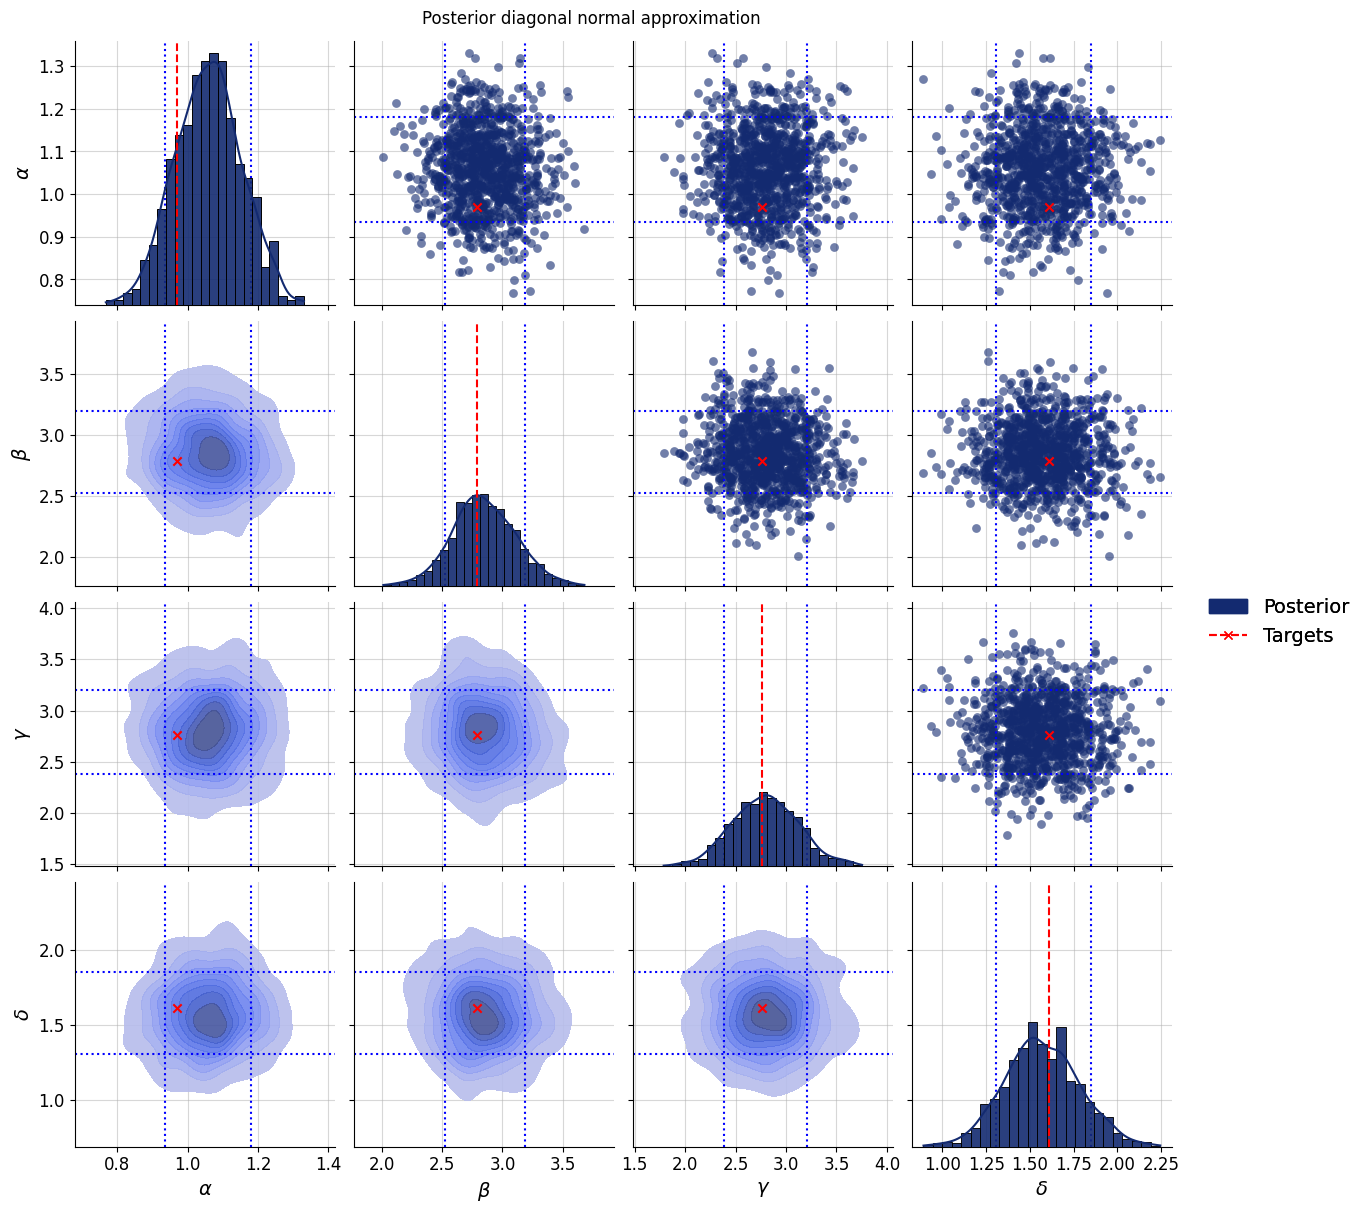

In [32]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws_from_quantiles,
    targets=val_sims,
    dataset_id=dataset_id,
    variable_names=par_names,
)

plot_boxes(g, post_bounds_from_quantiles, dataset_id)
g.fig.suptitle("Posterior diagonal normal approximation", y=1.01);

The dotted lines above are the estimated quantiles for the levels 0.1 and 0.9 and we see that the quantile based normal distribution generates consistent samples. Next, let us look at how the trajectories look like that correspond to parameters from this posterior.

In [33]:
def offline_posterior_sampler(post_draws, dataset_id, sample_id):
    posterior_sample_for_id = {var_key: post_draws[var_key][dataset_id, sample_id,...].squeeze() for var_key in post_draws.keys()}
    return posterior_sample_for_id

In [34]:
def take_dataset(sims, dataset_id):
    return {var_key: sims[var_key][dataset_id] for var_key in sims.keys()}

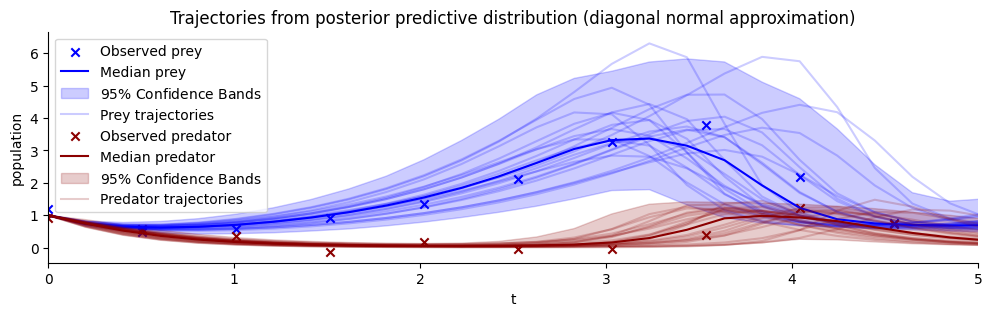

In [35]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws_from_quantiles, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution (diagonal normal approximation)");

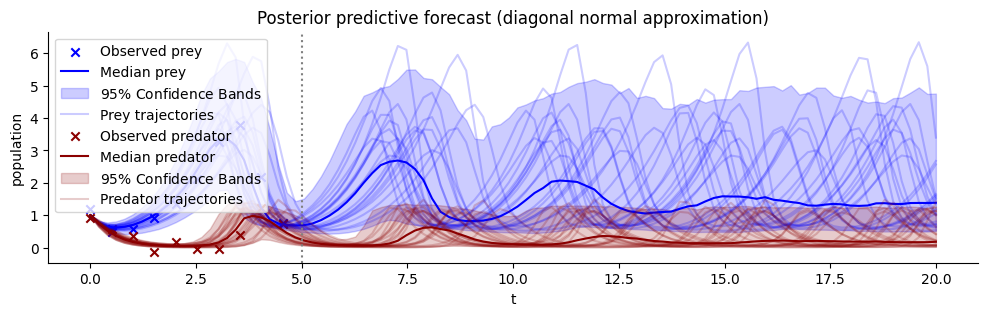

In [36]:
plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast (diagonal normal approximation)")
plt.axvline(5, color="grey", linestyle=":");

The trajectories appear to fit well to the observations. Compare this to the prior predictive distribution from above. The predictive distribution now only contains trajectories with reasonable period, lag and scale. In this sense we already were successful in updating our knowledge about possible Lotka-Volterra parameters that fit to the data.

If any issues are visible in the posterior diagnostics, we could now go back, make a change to the simulator to better match real world observations, add relevant expert statistics, or try simple learnt statistics. Then, we train and diagnose again and repeat until the point estimates seem trustworthy.

Bear in mind however, that while the approximations allowed us to iterate fast they also come with a cost. By neglecting multimodality and correlation the approximate posterior is likely to be undercontracted (overdispersed). The next sections will step by step remove those approximations. Because we already know what to expect from the model, we can move confidently towards more complicated and powerful posterior approximation methods.

## Full Posterior Approximation

Flow Matching is a powerful class of generative neural networks. Let try and see if we can use it as a drop-in replacement for the `PointInferenceNetwork` we used previously.

In [37]:
flow_matching = bf.networks.FlowMatching()

In [38]:
flow_matching_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=flow_matching,
)

Yes, we can!

We already know how to fit such a workflow. Flow matching performs well if you train it for a while. This takes a bit of time, but we will be rewarded by a tighter posterior approximation.

In [39]:
epochs = 50

In [ ]:
history = flow_matching_workflow.fit_offline(
    data=training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

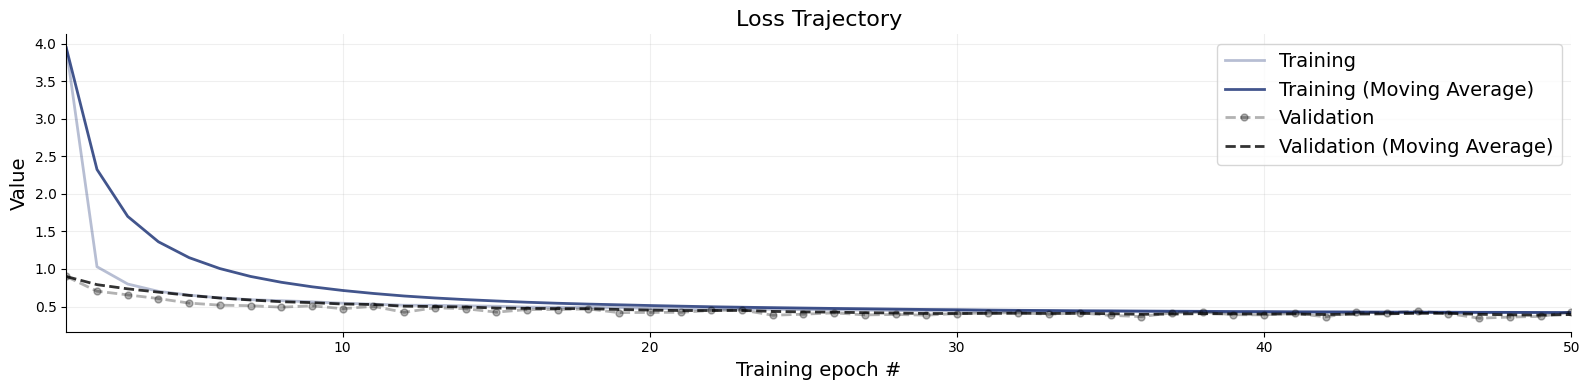

In [41]:
f = bf.diagnostics.loss(history)

Sampling the flow matching approximator takes much longer than estimating with the point approximator. To save time, we restrict the number of inference conditions:

In [42]:
val_sims = keras.tree.map_structure(lambda v: v[:100], val_sims)

In [43]:
%%time
# Set the number of posterior draws you want to get
num_samples = 100

# Obtain posterior draws with the sample method
post_draws = flow_matching_workflow.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys()

CPU times: total: 28.8 s
Wall time: 3.31 s


dict_keys(['alpha', 'beta', 'gamma', 'delta'])

Quickly training a point inference network 

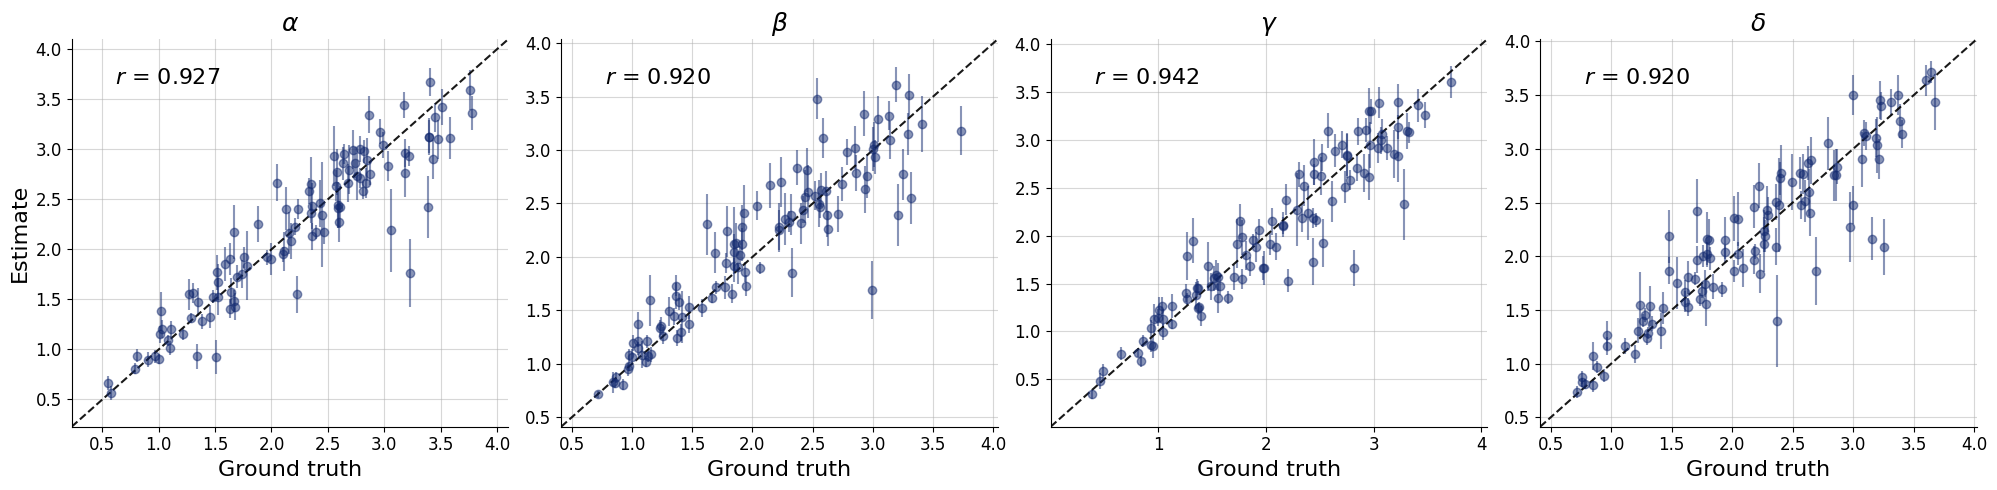

In [44]:
f = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)

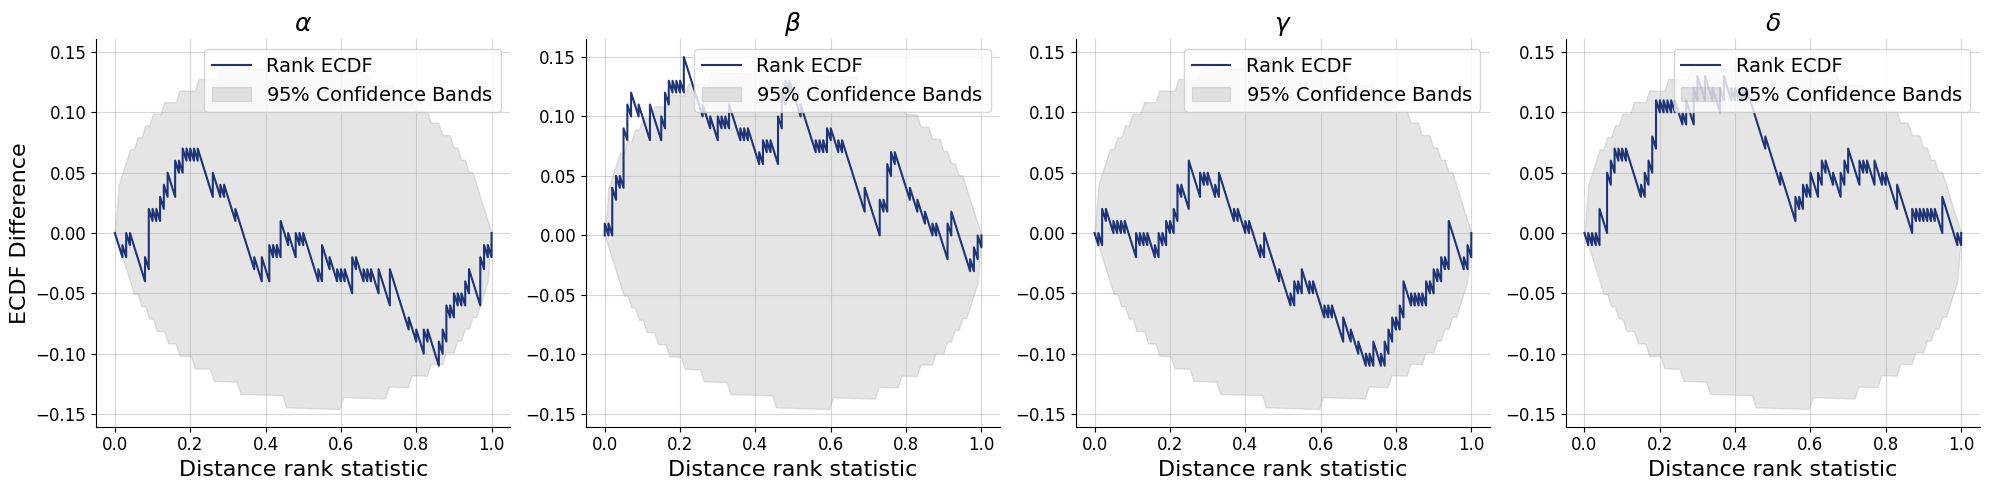

In [45]:
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

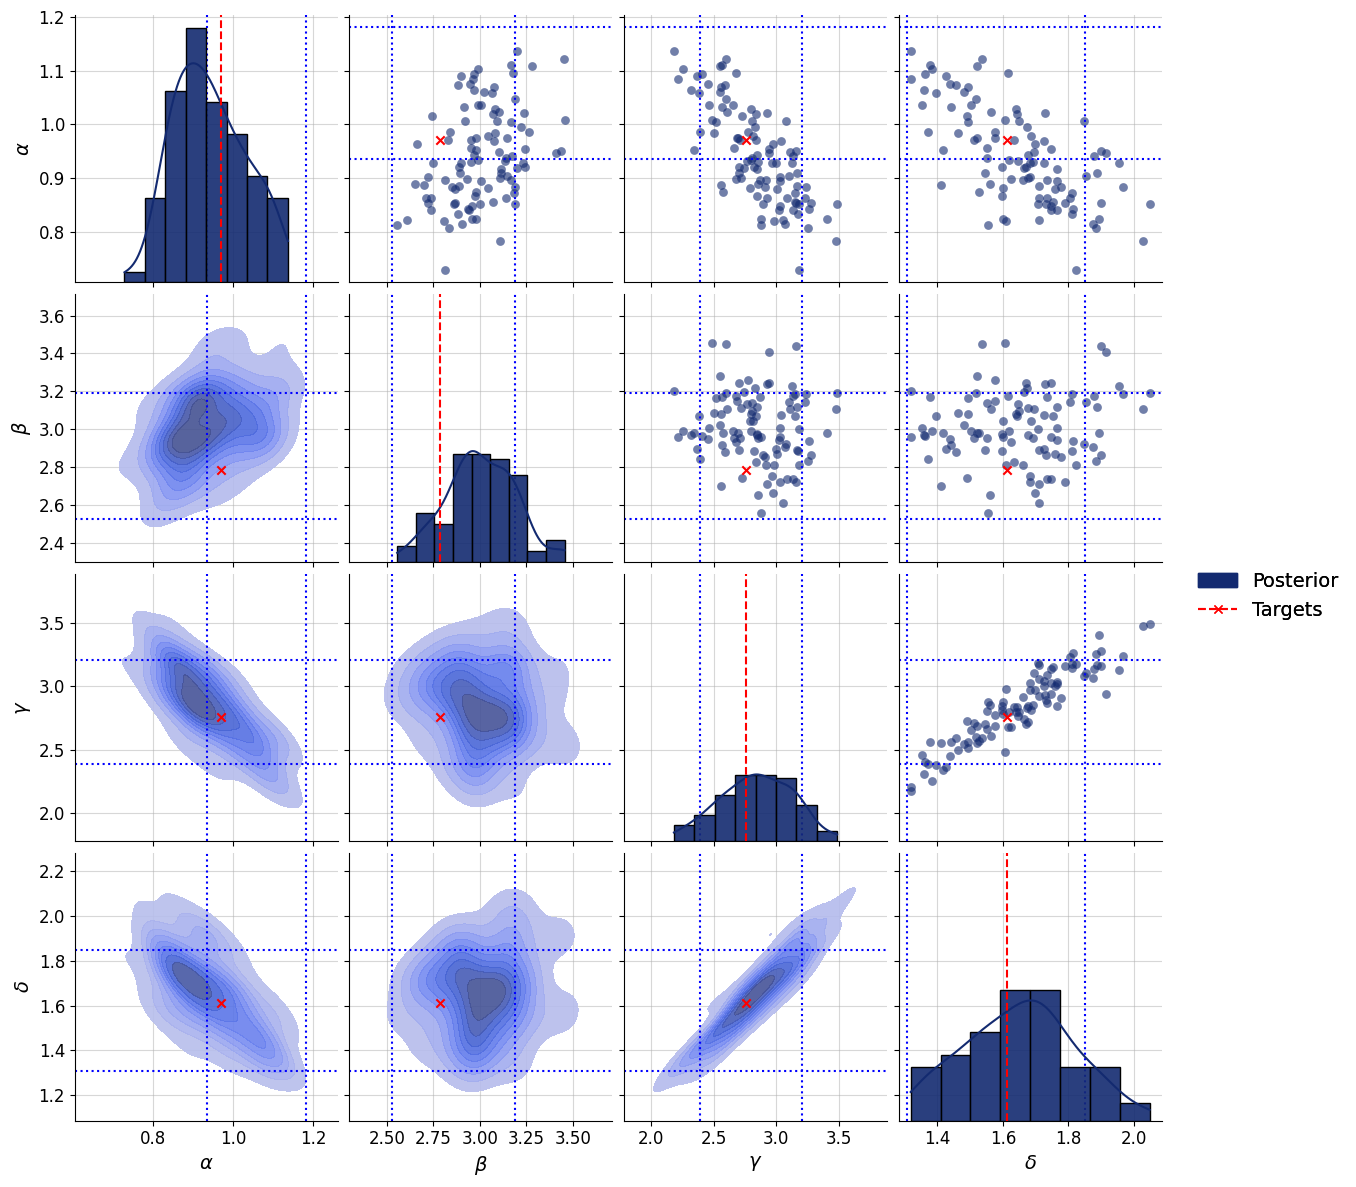

In [46]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=dataset_id,
    variable_names=par_names,
)

plot_boxes(g, post_bounds_from_quantiles, dataset_id)

Compared to the earlier approximate posterior draws we uncovered a strong correlation between parameters. Take a look at the marginals on the diagonal - the dotted quantile estimates still pass a visual consistency check. 

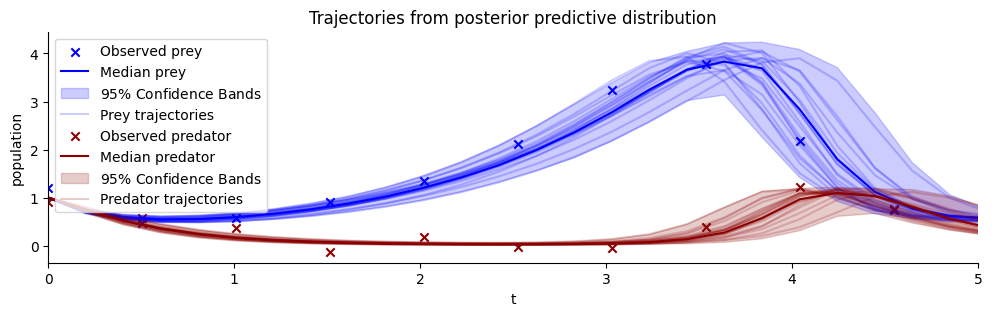

In [47]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution");

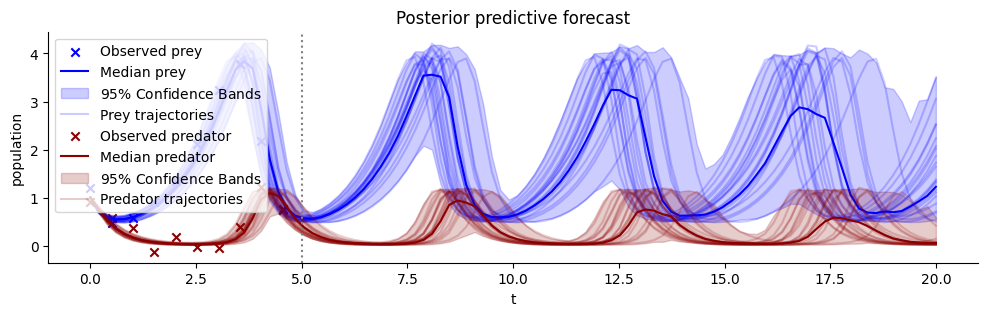

In [48]:
plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast")
plt.axvline(5, color="grey", linestyle=":");

Estimating the correlation of posterior samples has constrained the posterior predictive forecast uncertainty considerably!

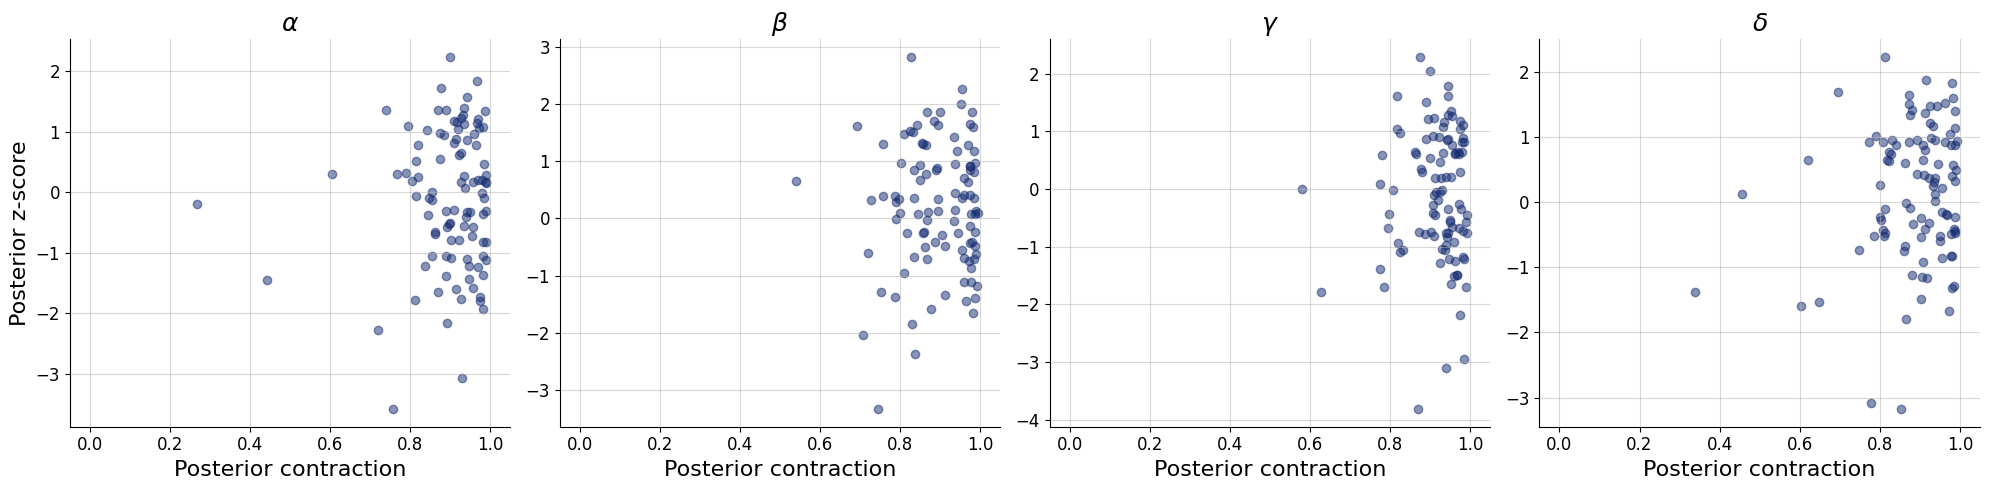

In [50]:
f = bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)

## End-to-end learning of summary statistics

In [51]:
summary_network = bf.networks.TimeSeriesNetwork()

In [52]:
learned_sumstat_adapter = (
    bf.adapters.Adapter()
    
    # convert any non-arrays to numpy arrays
    .to_array()
    
    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories
    .drop(["x", "y", "t"])

    # drop expert statistics
    .drop(["means", "log_vars", "auto_corrs", "cross_corr", "period"])

    # add a trailing dimension of 1
    .as_time_series(["observed_x", "observed_y", "observed_t"])
    
    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["observed_x", "observed_y", "observed_t"], into="summary_variables")
)
learned_sumstat_adapter

Adapter([0: ToArray -> 1: ConvertDType -> 2: Drop(['x', 'y', 't']) -> 3: Drop(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period']) -> 4: AsTimeSeries -> 5: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 6: Concatenate(['observed_x', 'observed_y', 'observed_t'] -> 'summary_variables')])

In [53]:
learned_sumstat_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=learned_sumstat_adapter,
    summary_network=summary_network,
    inference_network=bf.networks.FlowMatching(),
)

In [ ]:
history = learned_sumstat_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

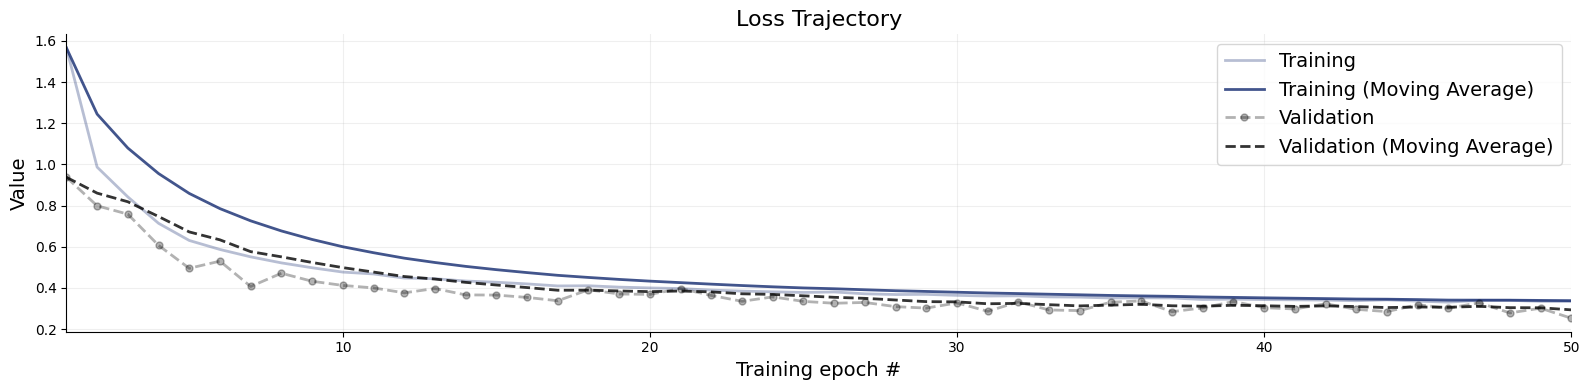

In [55]:
f = bf.diagnostics.loss(history)

Note, that the loss is lower since we are learning summary statistics simultaneously. How does this translate to visual diagnostics? We can check them again by sampling the posteriors of validation simulations not seen in training.

In [56]:
# Set the number of posterior draws you want to get
num_samples = 100

# Obtain posterior draws with the sample method
post_draws = learned_sumstat_workflow.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys()

dict_keys(['alpha', 'beta', 'gamma', 'delta'])

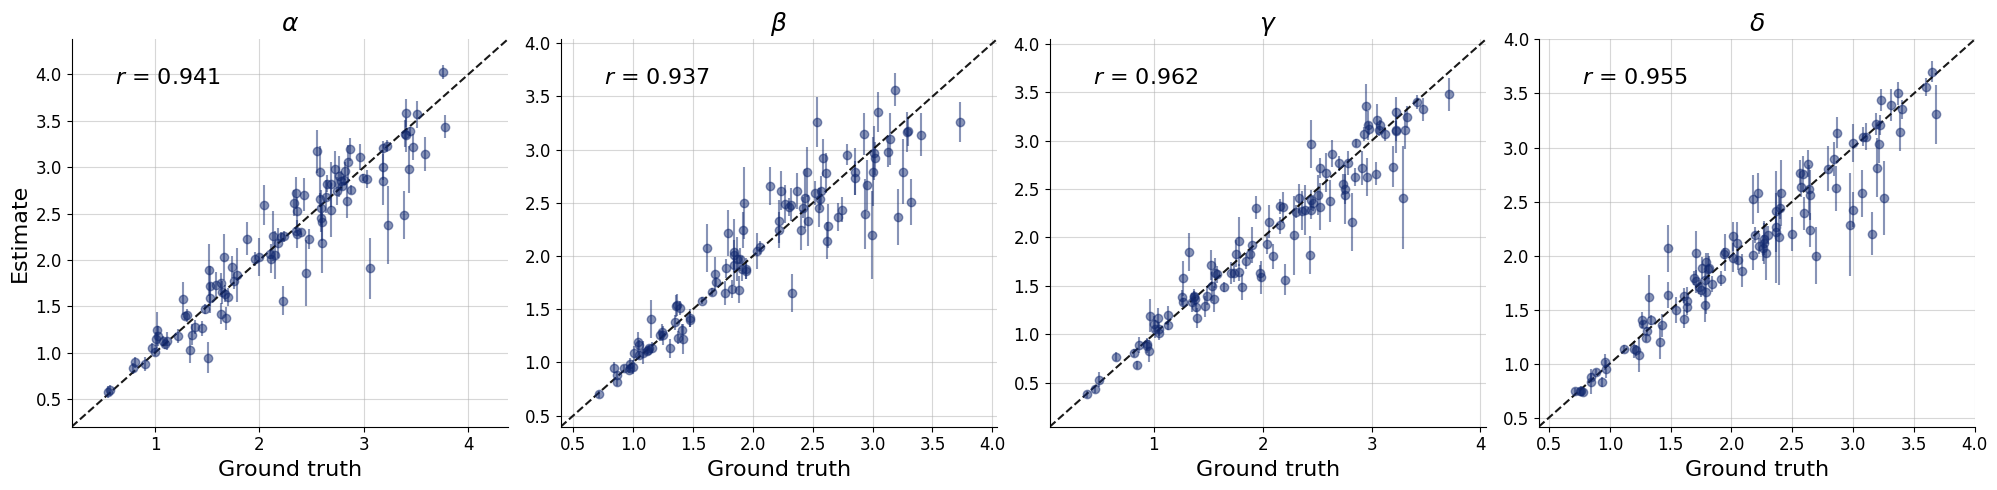

In [57]:
f = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)

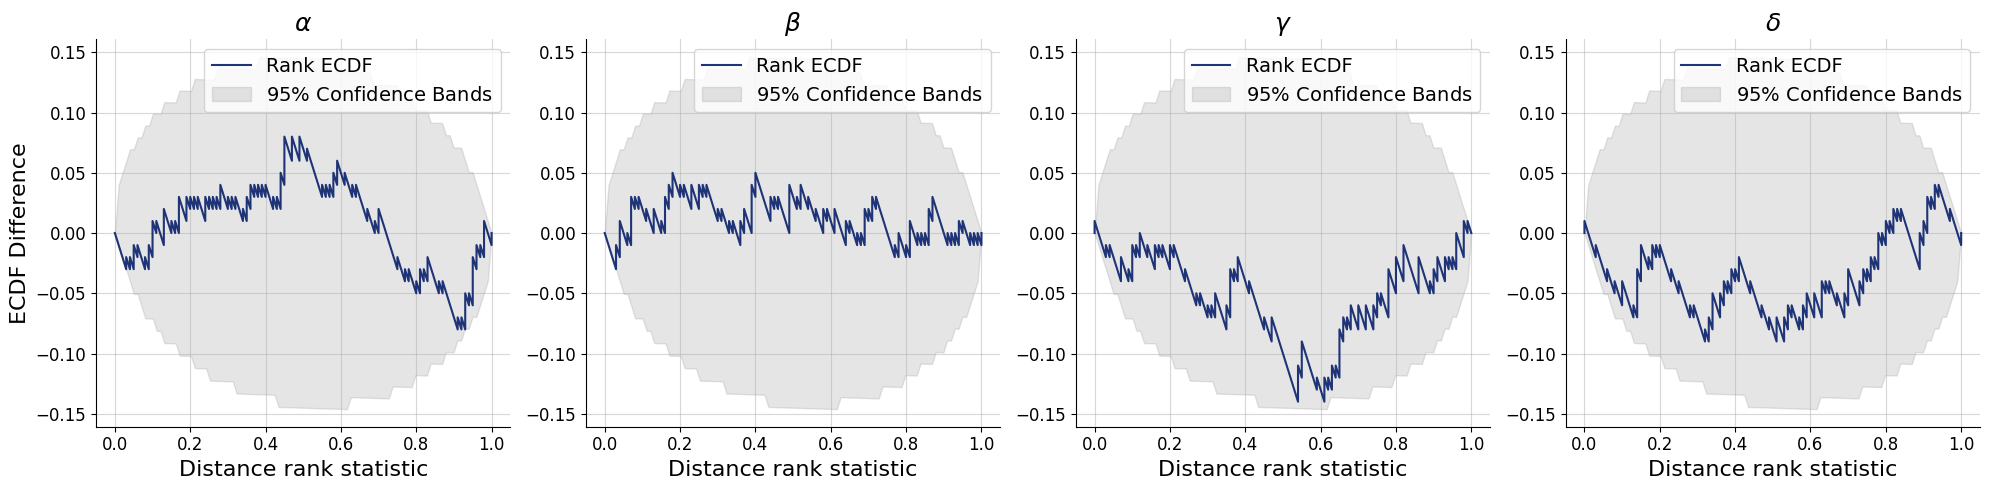

In [58]:
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

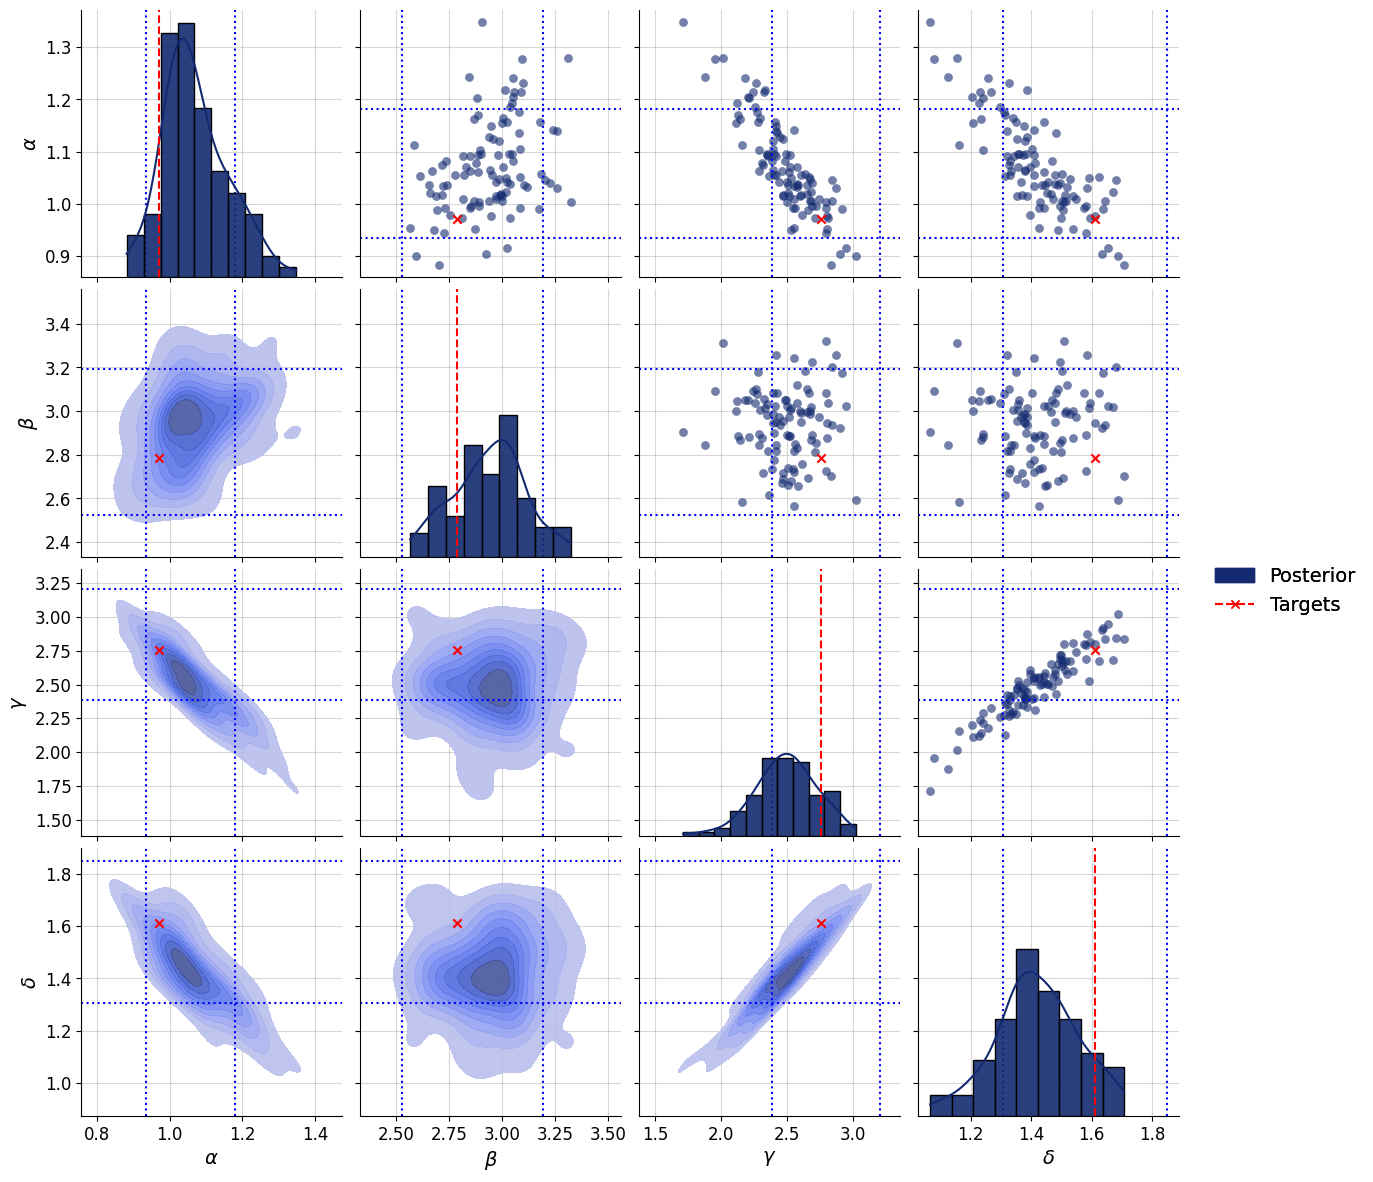

In [59]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=dataset_id,
    variable_names=par_names,
)
plot_boxes(g, post_bounds_from_quantiles, dataset_id)

Since the conditions changed now that we learn summaries of observations simultaneously to fitting the inference network, it is not surprising that posteriors seem to be shifted. You can compare how the new posterior samples relate to the dotted quantile estimates.

Neither expert-crafted nor jointly learnt statistics are guaranteed to be highly informative. However, to get to the global minimum of the training loss, the statistics need to be maximally informative. If architecture, training data and optimizer are well chosen, learnt summary statistics regularly outperform hand-crafted statistics.

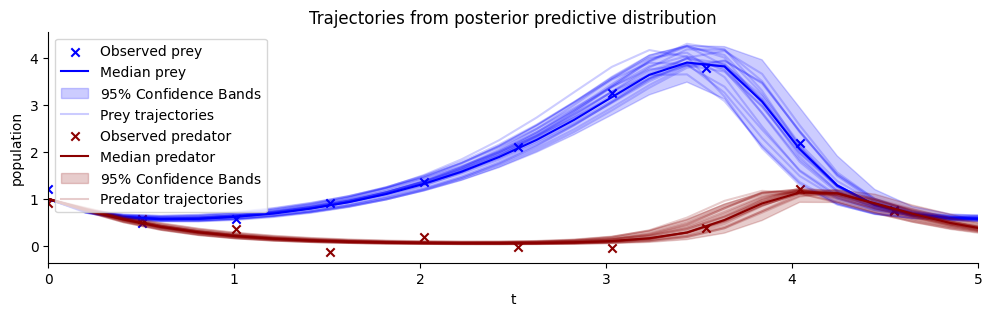

In [60]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution");

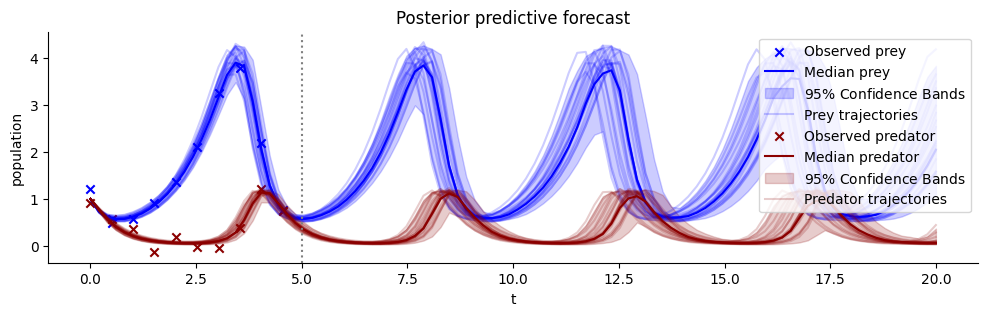

In [61]:
plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast")
plt.axvline(5, color="grey", linestyle=":");

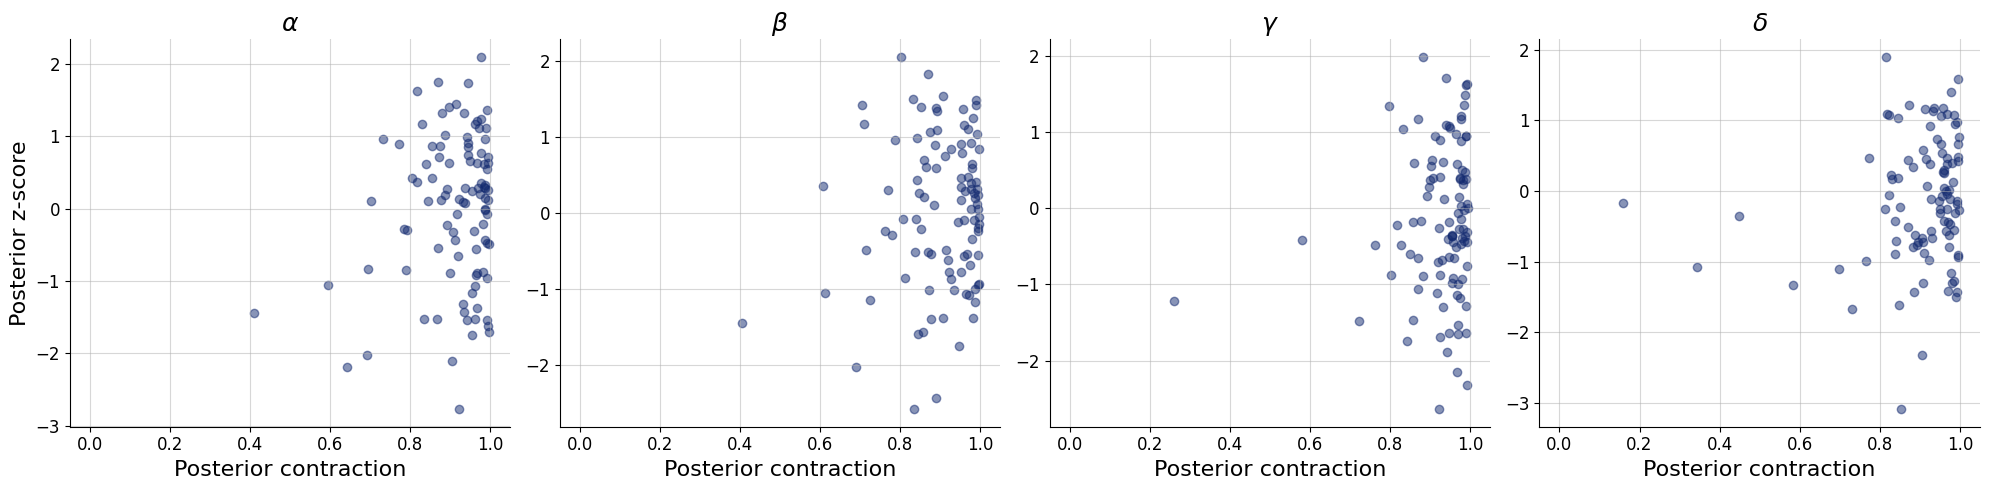

In [62]:
f = bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)